## New simulation setup

We assume that neither lender knows the fraction of H-type borrowers in the population, or how the signals are generated. They simply employ some learning algorithm, based on the utility of some action, and learn the best strategy.

The market consists of a fraction $\theta$ of H-type borrowers, and $1-\theta$ of L-type borrowers. There are two lenders, 1 and 2, and each of them will receive a signal from each borrower. We let $p_{s_1, s_2}^{t}$ denote the probability that a borrower of true type $t\in \{L, H\}$ will give a signal of $s_1$ to lender 1, and $s_2$ to lender $s_1$, where $s_1,s_2\in \{l, h\}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Constants

Market size $N$, fraction of H-type borrower $\theta$, and probabilities of signal generation.

$$
P^H = \begin{array}{cc}
p_{HH}^H, p_{HL}^H\\
p_{LH}^H, p_{LL}^H
\end{array}
$$

$$
P^L = \begin{array}{cc}
p_{HH}^L, p_{HL}^L\\
p_{LH}^L, p_{LL}^L
\end{array}
$$

In [124]:
N = 1000
# Theta = 0.9
Borrower_types = ['H', 'L']
Signals = ['hh', 'hl', 'lh', 'll']

phs = [
    np.array([[1, 0.0], 
            [0.0, 0.0]]),
    np.array([[0.90, 0.03], 
            [0.02, 0.05]]),
    np.array([[0.80, 0.10], 
            [0.05, 0.05]]),
    np.array([[0.70, 0.23], 
            [0.02, 0.05]]),
    np.array([[0.90, 0.03], 
            [0.02, 0.05]])
]
pls = [
    np.array([[0.05, 0.02],
            [0.03, 0.90]]),
    np.array([[0.05, 0.05],
            [0.10, 0.80]]),
    np.array([[0.05, 0.02],
            [0.23, 0.70]]),
    np.array([[0.02, 0.08],
            [0.18, 0.72]]), # this one the signals are independent
    np.array([[0.10, 0.06],
            [0.04, 0.80]]) 
]
Thetas = [0.9, 0.95, 0.97, 0.99, 0.9]

In [ ]:
settings_index = 4

PH = phs[settings_index]
PL = phs[settings_index]
Theta = Thetas[settings_index]

assert(PH.sum() == 1); assert(PL.sum() == 1)

### Generating borrowers with true types

In [125]:
Borrowers = np.random.choice(Borrower_types, size=N, p=[Theta, 1-Theta])
np.unique(Borrowers, return_counts=True)

(array(['H', 'L'], dtype='<U1'), array([899, 101]))

### Generating signals

In [126]:
def signal(true_type, PH, PL):
    if true_type == 'H':
        return np.random.choice(Signals, p=PH)
    elif true_type == 'L':
        return np.random.choice(Signals, p=PL)
    else:
        raise ValueError

In [127]:
ph_1d, pl_1d = PH.reshape(-1), PL.reshape(-1)
signals = [signal(b, ph_1d, pl_1d) for b in Borrowers]

In [128]:
lender1_signals = [s[0] for s in signals]
lender2_signals = [s[1] for s in signals]

In [129]:
np.unique(lender1_signals, return_counts=True), np.unique(lender2_signals, return_counts=True)

((array(['h', 'l'], dtype='<U1'), array([929,  71])),
 (array(['h', 'l'], dtype='<U1'), array([919,  81])))

### Wrapper

In [130]:
def gen_signals_for_one_round():
    borrowers = np.random.choice(Borrower_types, size=N, p=[Theta, 1-Theta])
    signals = [signal(b, ph_1d, pl_1d) for b in borrowers]
    lender1_signals = [s[0] for s in signals]
    lender2_signals = [s[1] for s in signals]
    return borrowers, lender1_signals, lender2_signals

In [131]:
br, l1, l2 = gen_signals_for_one_round()

In [132]:
np.unique(br, return_counts=True), np.unique(l1, return_counts=True), np.unique(l2, return_counts=True)

((array(['H', 'L'], dtype='<U1'), array([901,  99])),
 (array(['h', 'l'], dtype='<U1'), array([929,  71])),
 (array(['h', 'l'], dtype='<U1'), array([922,  78])))

In [133]:
print('Lender 1 expected number of h signals', N*Theta*PH[0].sum() + N*(1-Theta)*PL[0].sum())
print('Lender 2 expected number of h signals', N*Theta*PH[:,0].sum() + N*(1-Theta)*PL[:,0].sum())

Lender 1 expected number of h signals 930.0
Lender 2 expected number of h signals 920.0


In [134]:
from tqdm import tqdm

In [135]:
# option 1: both players are no-regret learners
# algorithm: hedge + propensity scoring

T = 200

# lender chooses r, lends to everyone of type H
# chooses r
# .. more complicated...


# let r_bar be the highest rate any H borrower would accept
r_bar = 1
n = 11
max_r = 0.2
rs = np.linspace(0, max_r, n)
rng = np.random.default_rng()
# for now: sample r_h, r_l indepedently



W1 = {
    'h': np.ones(n), 
    'l': np.ones(n)
}
W2 = {
    'h': np.ones(n), 
    'l': np.ones(n)
}
W1s = []
W2s = []

eps = 1e-2
def weight(c):
    return (1-eps)**c

def dist(w):
    return w / w.sum()

def update_Ws(W, c_t):
    for type in W.keys():
        w = weight(c_t[type])
        W[type] = W[type] *  w
    return W

for t in tqdm(range(T)):
    br, l1, l2 = gen_signals_for_one_round()

    c1_t = {
        'h': np.zeros(n),
        'l': np.zeros(n)
    }
    count1_t = {
        'h': np.zeros(n),
        'l': np.zeros(n)
    }
    c2_t = {
        'h': np.zeros(n),
        'l': np.zeros(n)
    }
    count2_t = {
        'h': np.zeros(n),
        'l': np.zeros(n)
    }
    for i, (b, l1_b, l2_b) in enumerate(zip(br, l1, l2)):
        j1 = rng.choice(n, p=dist(W1[l1_b]))
        j2 = rng.choice(n, p=dist(W2[l2_b]))

        r1 = rs[j1]
        r2 = rs[j2]
        
        c1, c2 = 0, 0

        if (r1 < r2) or (r2 == 0):
            c1 = -r1 if b == 'H' else 1
        if (r1 > r2) or (r1 == 0):
            c2 = -r2 if b == 'H' else 1

        if r1 == r2:
            if r1 == 0:
                c1, c2 = 0, 0
            else:
                c1, c2 = -r1 / 2, -r2 / 2 if b == 'H' else 1 / 2

        # c1 = c1 + 1
        # c2 = c2 + 1
        # cpdate c1_t
        c1_t[l1_b][j1] = c1_t[l1_b][j1] + c1
        count1_t[l1_b][j1] = count1_t[l1_b][j1] + 1

        # cpdate c2_t
        c2_t[l2_b][j2] = c2_t[l2_b][j2] + c2
        count2_t[l2_b][j2] = count2_t[l2_b][j2] + 1

    c1t_avg = {}
    for type in count1_t:
        c1t_avg[type] = np.divide(c1_t[type], count1_t[type], out=np.zeros_like(c1_t[type]), where= count1_t[type]!=0)

    c2t_avg = {}
    for type in count2_t:
        c2t_avg[type] = np.divide(c2_t[type], count2_t[type], out=np.zeros_like(c2_t[type]), where= count2_t[type]!=0)
    
    # update policies using HEDGE
    W1 = update_Ws(W1, c1t_avg)
    W2 = update_Ws(W2, c2t_avg)

    W1s.append(W1)
    W2s.append(W2)
    
    # print(dist(W1['h']))

100%|██████████| 200/200 [00:06<00:00, 29.11it/s]


In [136]:
# get the MW probability of selecting r=1
last_h1s = []
last_h2s = []

last_l1s = []
last_l2s = []
for W1_i, W2_i in zip(W1s, W2s):
    last_h1s.append(dist(W1_i['h'])[-1])
    last_h2s.append(dist(W2_i['h'])[-1])

    last_l1s.append(dist(W1_i['l'])[-1])
    last_l2s.append(dist(W2_i['l'])[-1])

# why is this all the same value? based on what I'm printing above, they should all be different...
# print(last_h1s)

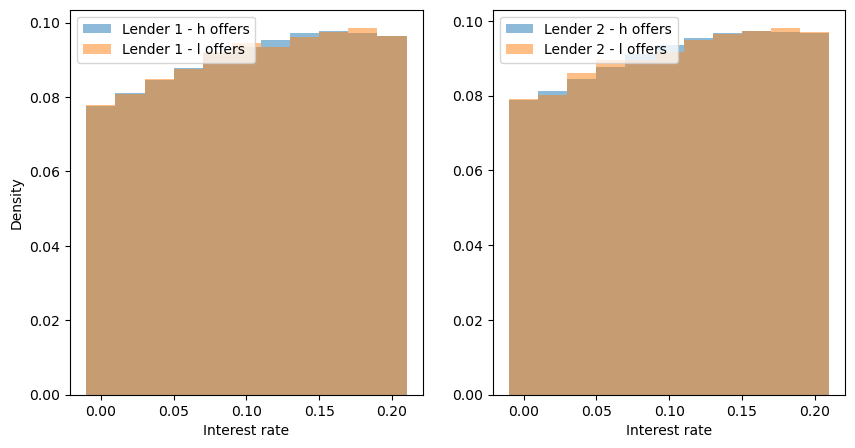

In [137]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].bar(rs, dist(W1['h']), alpha=0.5, width = max_r/(n-1), label='Lender 1 - h offers')
ax[0].bar(rs, dist(W1['l']), alpha=0.5, width = max_r/(n-1), label='Lender 1 - l offers')

ax[0].legend()

ax[1].bar(rs, dist(W2['h']), alpha=0.5, width = max_r/(n-1), label='Lender 2 - h offers')
ax[1].bar(rs, dist(W2['l']), alpha=0.5, width = max_r/(n-1), label='Lender 2 - l offers')
ax[1].legend()

# ylabel
ax[0].set_ylabel('Density')

# xlabel
ax[0].set_xlabel('Interest rate')
ax[1].set_xlabel('Interest rate')
plt.savefig(f'plots/MW_lender_offers_{str(settings_index)}.png')
plt.show()